## Jupyter Notebook for the creation of mdtraj obtained data plots and PCA/tICA analysis


- First you need to import the important libraries. Maybe you need to add more libraries. Feel free to add them in this first cell
- Then you can load the functions that will be used later on. Nice_PES ia a function for plotting FEL plots in a nice way


In [1]:
# Useful stuff
import numpy as np
from itertools import combinations
import os
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
import pandas as pd
import pytraj as pt
import glob

# PyEmma
import pyemma
import pyemma.msm as msm
import pyemma.plots as mpl
import pyemma.coordinates as coor

In [2]:
def plot_Nice_PES(P_test,bins=90,sigma=0.99, title=False, size = 1):

    mpl.style.use("seaborn-paper")
    plt.figure(figsize=(6*size,5*size))
    alldata=np.vstack(P_test)
    min1=np.min(alldata[:,0])
    max1=np.max(alldata[:,0])
    min2=np.min(alldata[:,1])
    max2=np.max(alldata[:,1])
    
    tickspacing1=1.0
    tickspacing2=1.0
    z,x,y = np.histogram2d(alldata[:,0], alldata[:,1], bins=bins)
    z += 0.1
    
    # compute free energies
    F = -np.log(z)
    
    
    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    
    plt.xticks(np.arange(int(min1), int(max1)+1, tickspacing1),fontsize=10*size)
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2),fontsize=10*size)
    #    sigma = 0.99 # this depends on how noisy your data is, play with it!
    data = gaussian_filter((F.T)*0.592-np.min(F.T)*0.592, sigma)
    levels=np.linspace(0,np.max(data)-0.5,num=10)
    plt.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
    plt.contourf(data,alpha=0.5,cmap='jet', cbar=True,levels=levels,extent=extent)
    if title:
        plt.title(title, fontsize = 20*size, y=1.02)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
    cax = plt.axes([0.81, 0.1, 0.02, 0.7])
    plt.colorbar(cax=cax, format='%.1f').set_label('Free energy (kcal/mol)', fontsize=10*size, labelpad=5, y= 0.5)
    cax.axes.tick_params(labelsize=10*size)

In [3]:
import matplotlib as mpl
#import nglview as nv
import ipywidgets as widgets
import pytraj as pt
import warnings
import tqdm
warnings.filterwarnings("ignore")
%pylab inline
%matplotlib inline

def interactive_FEL2(TICA_test, trajfiles, topfile, output_plot=True, n_frames=1,output_structure=False, size=1, bins=90, sigma=0.99, pc1=0, pc2=1):
    '''
        
        Plot the Free Energy Surface(FES) of the given data in a matplotlib pyqt. User can select a point in the FES. 
        
                
        If you experience some problem or you have any comment with this function --> https://github.com/miqueleg/compbiolab :3
        
        Parameters: ---------------------------------------------------------------------------------
        
        data: 3D ndarray (MD,frames,tic_dim). If not, the calculations will be wrong!!
        
        trajfiles: 1D array containing all trajectories strings containing files path and name(order in the list is important)
        
        topfile: string containing file path and name for the .pdb file that will be used as topology.
        
        output_plot: If true, a plot including the FES and selected pint will be displayed at the end.
            default=True
            
        output_structure: If True,the selected structure is also returned as pytraj structure.
            default=False
            
        size: Float/Integer that defines the size of the plots
            default=1
            
        
        Returns: -------------------------------------------------------------------------------------------
        
        - nglview of the structure selected
        
        - If output_structure=True, the selected structure is also returned as pytraj structure
        
        Only in in jupyter-notebook
          
    '''
    ##This imports are kind of necessary in order to plot the graphic in the Tk canvas(PQt5).
    ## At the end of the function, the matplotlib inline canvas has to be setted again in order to do not disturbe next plots
    %matplotlib qt

    ##Plot the Free energy surface as Nice_PES function
    mpl.style.use("seaborn-paper")
    fig, ax = plt.subplots(figsize=(6*size,5*size))
    alldata=np.vstack(TICA_test)
    min1=np.min(alldata[:,pc1])
    max1=np.max(alldata[:,pc1])
    min2=np.min(alldata[:,pc2])
    max2=np.max(alldata[:,pc2])
    print(all_data.shape)

    tickspacing1=1.0
    tickspacing2=1.0
    z,x,y = np.histogram2d(alldata[:,pc1], alldata[:,pc2], bins=bins)
    z += 0.1

    # compute free energies
    F = -np.log(z)

    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]

    plt.xticks(np.arange(int(min1), int(max1)+1, tickspacing1),fontsize=10*size)
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2),fontsize=10*size)
    #    sigma = 0.99 # this depends on how noisy your data is, play with it!
    data = gaussian_filter((F.T)*0.592-np.min(F.T)*0.592, sigma)
    levels=np.linspace(0,np.max(data)-0.5,num=8)
    ax.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
    ax.contourf(data,alpha=0.5,cmap='jet', cbar=True,levels=levels,extent=extent)

    ##ginput will wait until a click is done into the plot and collect the coordinates into the x variable
    x = plt.ginput()


    #nodes are the prepared data corresponding of the points on the TICA scatter (tic0 and tic1 by default)
    nodes = np.array(list(zip(alldata[:,pc1],alldata[:,pc2])))
    node = np.array(x[0])
    #cdist finction computes the distance matrix between TICA nodes and node
    distances = np.array(cdist([node], nodes))
    #clicked frame is the position in the matrix distance in wich you can find the minimun value
    clicked_frames = np.argsort(distances)[0]
    clicked_frames = clicked_frames[:n_frames]
    MD_out = pt.Trajectory(top=topfile)
    
    for f in tqdm.tqdm(range(len(clicked_frames))):
        clicked_frame = clicked_frames[f]
        MD=pt.iterload(trajfiles, top=topfile)
        MD_out.append(MD[clicked_frame])

        #Frames is a list containing the len of all the MD's.
        #This forces the input TICA_test to have a 3D shape (MD,frames,tic_dim). If not, the calculations are wrong!!
        Frames = []
        for traj in TICA_test:
            Frames.append(len(traj))
        #In this loop is computed in wich MD and MD_frame you can find the clicked frame
        MD = 0
        Frame = clicked_frame
        for i in list(range(len(Frames))):
            sum_frames = sum([Frames[j] for j in list(range(len(Frames))) if j <= i])
            if clicked_frame <= sum_frames:
                MD = i
                Frame = clicked_frame - sum([Frames[j] for j in list(range(len(Frames))) if j < i])
                break
            else:
                continue
    #The selected_frame is displayed using pytraj and nglview
    MD=pt.iterload(trajfiles, top=topfile)
    view=nv.show_pytraj(MD)
    view.clear()
    view.add_cartoon(selection="protein")
    view.frame = int(clicked_frame)

    #returning to the matplotlib inline
    %matplotlib inline
    #plot the selected position with a scatter
    if output_plot:
        plt.figure(figsize=(6*size,5*size))
        plt.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
        plt.contourf(data,alpha=0.2,cmap='jet', cbar=True,levels=levels,extent=extent)
        plt.scatter(np.array(x)[:,0],np.array(x)[:,1], c ='b', s =50)
    if output_structure:
        return view, MD_out
    else:
        return view


Populating the interactive namespace from numpy and matplotlib


# 1 - Discretization

I start by defining the input files names and the input coordinates

In [4]:
directo='/home/janet/Desktop/HSVTK/APO/'
trajfiles_APO=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_APO='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_APO.pdb'

directo='/home/janet/Desktop/HSVTK/APO_MG/'
trajfiles_APOMG=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_APOMG='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_APO_MG.pdb'

directo='/home/janet/Desktop/HSVTK/THM/'
trajfiles_THM=[fi for fi in glob.glob
               (directo + '*_super.dcd')]
topfile_THM='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_THM.pdb'

directo='/home/janet/Desktop/HSVTK/GCV/'
trajfiles_GCV=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_GCV='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_GCV.pdb'

directo='/home/janet/Desktop/HSVTK/THM_ATP/'
trajfiles_THM_ATP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_THM_ATP='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_THM_ATP.pdb'

directo='/home/janet/Desktop/HSVTK/GCV_ATP/'
trajfiles_GCV_ATP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_GCV_ATP='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_GCV_ATP.pdb'

In [5]:
trajfiles_GCV_ATP


['/home/janet/Desktop/HSVTK/GCV_ATP/dyn_MD_1E2K_GCV_ATP1_super.dcd',
 '/home/janet/Desktop/HSVTK/GCV_ATP/dyn_MD_1E2K_GCV_ATP2_super.dcd',
 '/home/janet/Desktop/HSVTK/GCV_ATP/dyn_MD_1E2K_GCV_ATP3_super.dcd']

In [6]:
trajfiles = []
# trajfiles.append(trajfiles_APO)
# trajfiles.append(trajfiles_APOMG)
# trajfiles.append(trajfiles_THM)
# trajfiles.append(trajfiles_GCV)
trajfiles.append(trajfiles_THM_ATP)
trajfiles.append(trajfiles_GCV_ATP)
#trajfiles.append(trajfiles_TMP_ADP)
#trajfiles.append(trajfiles_GMP_ADP)
topfiles = []
# topfiles.append(topfile_APO)
# topfiles.append(topfile_APOMG)
# topfiles.append(topfile_THM)
# topfiles.append(topfile_GCV)
topfiles.append(topfile_THM_ATP)
topfiles.append(topfile_GCV_ATP)
#topfiles.append(topfile_TMP_ADP)
#topfiles.append(topfile_TMP_ADP)

In [7]:
t = md.iterload(trajfiles[0],top=topfiles[0])

In [11]:
%%time
contacts= md.compute_contacts(t, scheme= 'closest-heavy', ignore_nonprotein=False)

AttributeError: 'generator' object has no attribute 'topology'

In [13]:
topfiles[0]

'/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_THM_ATP.pdb'

## analysis:

In [16]:
feat1.select("resid 206 to 23")

array([3154, 3155, 3156, ..., 3614, 3615, 3616])

We normaly organize the data as the following: 
- FEATS are the lists variables that contains the data that will be used to extract info from the MD's (only based in the topfile). Feats list contain the feats for all systems. ej: feat1 == feats[0]
- SOURCES are the arrays containing the values of the feats for all frames

In [59]:
feat1=pyemma.coordinates.featurizer(topfiles[0])
topsele=feat1.select('resid 661 to 662')
around =feat1.select(  # Features selected CA coordinates. The trajectories MUST be aligned first!
print(all_Ca1)            # if you want to avoid the aligning, you can use: feat1.add_distances_ca()
feat1.add_selection(topsele, around)

[10047 10048 10049 ... 10118 10119 10120]


# PCA / TICA

In [74]:
feat1=pyemma.coordinates.featurizer(topfiles[0])
all_Ca1=feat1.select('resid 661 to 662') # Features selected CA coordinates. The trajectories MUST be aligned first!
print(all_Ca1)            # if you want to avoid the aligning, you can use: feat1.add_distances_ca()
feat1.add_residue_mindist(all_Ca1)

feat2=pyemma.coordinates.featurizer(topfiles[1])
all_Ca2=feat2.select('resid 661 to 662')
print(all_Ca2)
feat2.add_residue_mindist(all_Ca2)

#feat3=pyemma.coordinates.featurizer(topfiles[2])
#all_Ca3=feat3.select_Ca()
#print(all_Ca3)
#feat3.add_selection(all_Ca3)

#feat4=pyemma.coordinates.featurizer(topfiles[3])
#all_Ca4=feat4.select_Ca()
#print(all_Ca4)
#feat4.add_selection(all_Ca4)

#feat5=pyemma.coordinates.featurizer(topfiles[4])
#all_Ca5=feat5.select_Ca()
#print(all_Ca5)
#feat5.add_selection(all_Ca5)

#feat6=pyemma.coordinates.featurizer(topfiles[5])
#all_Ca6=feat6.select_Ca()
#print(all_Ca6)
#feat6.add_selection(all_Ca6)

#feat7=pyemma.coordinates.featurizer(topfiles[6])
#all_Ca7=feat7.select_Ca()
#print(all_Ca7)
#feat7.add_selection(all_Ca7)

#feat8=pyemma.coordinates.featurizer(topfiles[7])
#all_Ca8=feat8.select_Ca()
#print(all_Ca8)
#feat8.add_selection(all_Ca8)

#feat9=pyemma.coordinates.featurizer(topfiles[8])
#all_Ca9=feat9.select_Ca()
#print(all_Ca9)
#feat9.add_selection(all_Ca9)

[10047 10048 10049 ... 10118 10119 10120]


ValueError: contacts must be ndim 2. You supplied 1

In [63]:
 feat2

MDFeaturizer with features:
['ATOM:GA2 662 O2 10047 5 x',
 'ATOM:GA2 662 O2 10047 5 y',
 'ATOM:GA2 662 O2 10047 5 z',
 'ATOM:GA2 662 H10 10048 5 x',
 'ATOM:GA2 662 H10 10048 5 y',
 'ATOM:GA2 662 H10 10048 5 z',
 'ATOM:GA2 662 C5 10049 5 x',
 'ATOM:GA2 662 C5 10049 5 y',
 'ATOM:GA2 662 C5 10049 5 z',
 'ATOM:GA2 662 H4 10050 5 x', ...]

In [64]:
print(len(feat1.describe()))
print(len(feat2.describe()))
#print(len(feat3.describe()))
#print(len(feat4.describe()))
#print(len(feat5.describe()))
#print(len(feat6.describe()))
#print(len(feat7.describe()))
#print(len(feat8.describe()))
#print(len(feat9.describe()))

222
222


In [65]:
feats=[]
feats.append(feat1)
feats.append(feat2)
#feats.append(feat3)
#feats.append(feat4)
#feats.append(feat5)
#feats.append(feat6)
#feats.append(feat7)
#feats.append(feat8)
#feats.append(feat9)

In [66]:
# This may take a while

sources=[]
print (len(feats[0].describe()))
for traj in range(0,len(topfiles)):
    print (traj,len(trajfiles))
    sources.append(pyemma.coordinates.load(trajfiles[traj],features=feats[traj]))

222
0 2


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

1 2


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

In [67]:
np.array(sources).shape

(2, 3, 25000, 222)

In [68]:
joint_data = sources[0] + sources[1]

## PCA

- Here the PCA space is created using all the data from all the systems. This can be done if we have the same features for all the different systems.
- Later on, the data is splitted for the different systems, but the space is the same

In [69]:
pca_joint=pyemma.coordinates.pca(data=joint_data,kinetic_map=False,stride=1)
pca_Y = pca_joint.get_output()
pca_THM_ATP, pca_GCV_ATP= np.split(pca_Y, np.cumsum(list(map(len, trajfiles)))[:-1])

calc mean+cov:   0%|          | 0/6 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/6 [00:00<?, ?it/s]

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

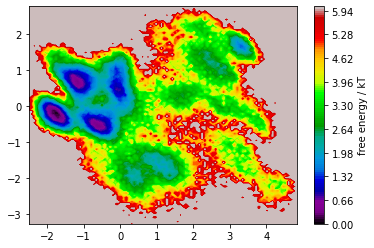

In [70]:
all_data=np.vstack(pca_Y)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

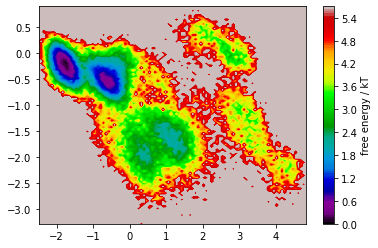

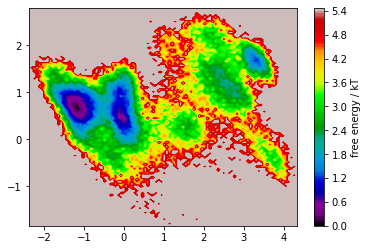

In [71]:
# all_data=np.vstack(pca_APO)
# pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

# all_data=np.vstack(pca_APOMG)
# pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

# all_data=np.vstack(pca_THM)
# pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

# all_data=np.vstack(pca_GCV)
# pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

all_data=np.vstack(pca_THM_ATP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

all_data=np.vstack(pca_GCV_ATP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

#all_data=np.vstack(pca_THM_ADP)
#pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

#all_data=np.vstack(pca_GCV_ADP)
#pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)


Here you will see the contributions of each feat (or the most important feats) for each PCA dimension (PC)

In [72]:
dist_PCA_correl = pca_joint.feature_PC_correlation

n_argmax = 2
for ii, icorr in enumerate(dist_PCA_correl.T):
    print("For PCA %u"%ii)
    argmaxs = [ii for ii in np.abs(icorr).argsort()[::-1] if not np.isnan(icorr[ii])]
    for art in argmaxs[:10]:
        print(str(art)+' %s %3.2f'%(feats[0].describe()[art], icorr[art]))
    print()

For PCA 0
169 ATOM:ATP 663 C5 10103 6 y 0.99
172 ATOM:ATP 663 C6 10104 6 y 0.99
175 ATOM:ATP 663 N6 10105 6 y 0.98
196 ATOM:ATP 663 C4 10112 6 y 0.98
181 ATOM:ATP 663 H61 10107 6 y 0.98
178 ATOM:ATP 663 H60 10106 6 y 0.98
184 ATOM:ATP 663 N1 10108 6 y 0.97
166 ATOM:ATP 663 N7 10102 6 y 0.97
193 ATOM:ATP 663 N3 10111 6 y 0.96
187 ATOM:ATP 663 C2 10109 6 y 0.95

For PCA 1
41 ATOM:THM 662 H5 10060 5 z -0.86
17 ATOM:THM 662 C4 10052 5 z -0.85
50 ATOM:THM 662 H2 10063 5 z -0.83
212 ATOM:ATP 663 C2* 10117 6 z 0.83
215 ATOM:ATP 663 H20 10118 6 z 0.82
200 ATOM:ATP 663 C3* 10113 6 z 0.82
203 ATOM:ATP 663 H30 10114 6 z 0.80
85 ATOM:THM 662 H10 10075 5 y 0.78
8 ATOM:THM 662 C5 10049 5 z -0.78
128 ATOM:ATP 663 O2A 10089 6 z 0.77

For PCA 2
60 ATOM:THM 662 C8 10067 5 x 0.89
54 ATOM:THM 662 C6 10065 5 x 0.87
63 ATOM:THM 662 C10 10068 5 x 0.86
75 ATOM:THM 662 C9 10072 5 x 0.85
78 ATOM:THM 662 O5 10073 5 x 0.85
66 ATOM:THM 662 H12 10069 5 x 0.84
51 ATOM:THM 662 N1 10064 5 x 0.80
16 ATOM:THM 662 C4 100

In [ ]:
For PCA 0
594
603
599
591
595
592
600
596
598
597

For PCA 1
176
174
175
177
131
132
138
172
189
130

In [20]:
import pickle

pickle.dump(pca_Y, open ("COMPARATIVE_FEL/PCA_5-6/pca_Y.p", "wb"))
# pickle.dump(pca_APO, open ("COMPARATIVE_FEL/PCA_1-2/pca_APO.p", "wb"))
# pickle.dump(pca_APOMG, open ("COMPARATIVE_FEL/PCA_1-2/pca_APOMG.p", "wb"))
#pickle.dump(pca_THM, open ("COMPARATIVE_FEL/PCA_3-4/pca_THM.p", "wb"))
pickle.dump(pca_THM_ATP, open ("COMPARATIVE_FEL/PCA_5-6/pca_THM_ATP.p", "wb"))
#pickle.dump(pca_THM_ADP, open ("PCA/pca_THM_ADP.p", "wb"))
#pickle.dump(pca_GCV, open ("COMPARATIVE_FEL/PCA_3-4/pca_GCV.p", "wb"))
pickle.dump(pca_GCV_ATP, open ("COMPARATIVE_FEL/PCA_5-6/pca_GCV_ATP.p", "wb"))
#pickle.dump(pca_GCV_ADP, open ("PCA/pca_GCV_ADP.p", "wb"))

## tICA

The biggest difference between PCA and tICA is the introduction of the lag time parameter. With this parameter we can ignore fast movements that are not important for the system like vibrations and side chain rotations. Is important to chose a propper lag time that reduces the number of dimensions that explains the variations in the MD's.

To select a initial lag time, we use this code to sample different values and we select the one that explains the same variation in less dimensions (minimum in the plot)

###### This part may take a while

calculate covariances:   0%|          | 0/6 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/6 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/6 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/6 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/6 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/6 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/6 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/6 [00:00<?, ?it/s]

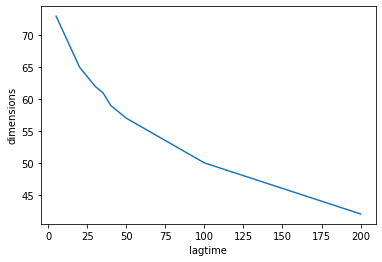

[5, [5, 73]]
[20, [20, 65]]
[30, [30, 62]]
[35, [35, 61]]
[40, [40, 59]]
[50, [50, 57]]
[100, [100, 50]]
[200, [200, 42]]


In [73]:
#Compute TICA on the combined data from all trajectories

multi_tica=[]

for i in [5,20,30,35,40,50,100,200]:
    tica_joint=pyemma.coordinates.tica(data=[t for t in joint_data if len(t)>1500],lag=i,stride=1)
    multi_tica.append([i,[tica_joint.lag, tica_joint.ndim]])
    del(tica_joint)
    
plt.plot([t[1][0] for t in multi_tica], [t[1][1]for t in multi_tica])
plt.xlabel('lagtime')
plt.ylabel('dimensions')
plt.show()
for tica in multi_tica:
    print(tica) 

## TICA

In [1]:
#%%time
lag=30   # We add the lag time that we selected in the previous part
tica_joint=pyemma.coordinates.tica(data=joint_data,lag=lag,kinetic_map=False,stride=1)
#kmeans=pyemma.coordinates.cluster_kmeans(data=None,k=25,max_iter=100)
#disc = pyemma.coordinates.discretizer(joint_data,transform=tica_joint,cluster=kmeans,stride=1)

#We get the output from tica on the combined dataset
Y_test = tica_joint.get_output()

#We know divide the tica output to recover the tica object for each dataset, i.e. tica for WT, tica for Lovd1..

tica_THM_ATP, tica_GCV_ATP = np.split(Y_test, np.cumsum(list(map(len, trajfiles)))[:-1])

NameError: name 'pyemma' is not defined

In [23]:
tica_THM_ATP.shape

(3, 25000, 557)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

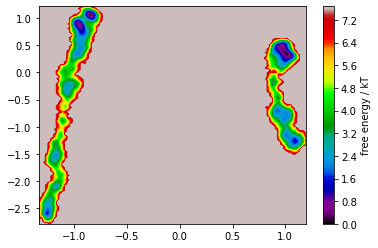

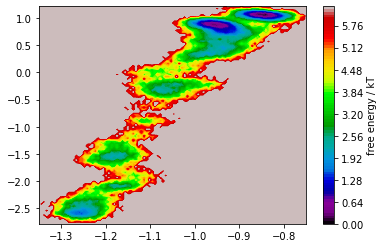

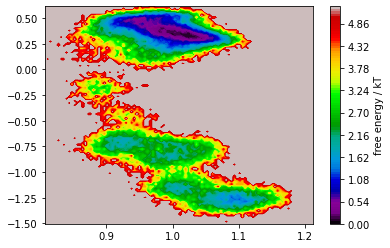

In [20]:
#We now compute the free energy of the combined dataset and separated datasets

dims = 0,1

all_data=np.vstack(Y_test)
pyemma.plots.plot_free_energy(all_data[:,dims[0]], all_data[:,dims[1]], avoid_zero_count=1)

# all_data_0=np.vstack(tica_APO)
# pyemma.plots.plot_free_energy(all_data_0[:,dims[0]], all_data_0[:,dims[1]], avoid_zero_count=1)

# all_data_1=np.vstack(tica_APOMG)
# pyemma.plots.plot_free_energy(all_data_1[:,dims[0]], all_data_1[:,dims[1]], avoid_zero_count=1)

# all_data_3=np.vstack(tica_THM)
# pyemma.plots.plot_free_energy(all_data_3[:,dims[0]], all_data_3[:,dims[1]], avoid_zero_count=1)

# all_data_6=np.vstack(tica_GCV)
# pyemma.plots.plot_free_energy(all_data_6[:,dims[0]], all_data_6[:,dims[1]], avoid_zero_count=1)

all_data_4=np.vstack(tica_THM_ATP)
pyemma.plots.plot_free_energy(all_data_4[:,dims[0]], all_data_4[:,dims[1]], avoid_zero_count=1)

all_data_7=np.vstack(tica_GCV_ATP)
pyemma.plots.plot_free_energy(all_data_7[:,dims[0]], all_data_7[:,dims[1]], avoid_zero_count=1)

#all_data_5=np.vstack(tica_THM_ADP)
#pyemma.plots.plot_free_energy(all_data_5[:,dims[0]], all_data_5[:,dims[1]], avoid_zero_count=1)

#all_data_8=np.vstack(tica_GCV_ADP)
#pyemma.plots.plot_free_energy(all_data_8[:,dims[0]], all_data_8[:,dims[1]], avoid_zero_count=1)

In [ ]:
For TIC 0
523
522
574
571
573
572
520
524
455
525
526
458
521
459
454
461
519
527
528
456

For TIC 1
227 
228 
370 
229 
369 
226 
656 
377 
657 
653 
651 
373 
231 
650 
232 
654 
658 
647 
655 
366

In [25]:
dist_TIC_correl = tica_joint.feature_TIC_correlation

n_argmax = 2
for ii, icorr in enumerate(dist_TIC_correl.T):
    print("For TIC %u"%ii)
    argmaxs = [ii for ii in np.abs(icorr).argsort()[::-1] if not np.isnan(icorr[ii])]
    for art in argmaxs[:20]:
        print(str(art)+' %s %3.2f'%(feats[0].describe()[art], icorr[art]))
    print()

For TIC 0
1566 ATOM:TYR 523 CA 7951 1 x 0.81
1563 ATOM:VAL 522 CA 7935 1 x 0.81
1719 ATOM:THR 574 CA 8698 1 x 0.80
1710 ATOM:THR 571 CA 8645 1 x 0.80
1716 ATOM:PHE 573 CA 8678 1 x 0.80
1713 ATOM:LEU 572 CA 8659 1 x 0.79
1557 ATOM:ARG 520 CA 7887 1 x 0.79
1569 ATOM:GLY 524 CA 7972 1 x 0.78
1362 ATOM:CYS 455 CA 6873 1 x 0.78
1572 ATOM:LEU 525 CA 7979 1 x 0.78
1575 ATOM:LEU 526 CA 7998 1 x 0.78
1371 ATOM:ALA 458 CA 6919 1 x 0.78
1560 ATOM:ARG 521 CA 7911 1 x 0.77
1374 ATOM:ALA 459 CA 6929 1 x 0.76
1359 ATOM:LEU 454 CA 6854 1 x 0.75
1380 ATOM:TYR 461 CA 6963 1 x 0.75
1554 ATOM:ILE 519 CA 7868 1 x 0.75
1578 ATOM:ALA 527 CA 8017 1 x 0.75
1581 ATOM:ASN 528 CA 8027 1 x 0.75
1365 ATOM:TYR 456 CA 6884 1 x 0.74

For TIC 1
679 ATOM:ALA 227 CA 3433 0 y -0.89
682 ATOM:GLU 228 CA 3443 0 y -0.89
1108 ATOM:THR 370 CA 5631 1 y 0.87
685 ATOM:PRO 229 CA 3466 0 y -0.86
1105 ATOM:MET 369 CA 5614 1 y 0.85
676 ATOM:GLY 226 CA 3426 0 y -0.85
1966 ATOM:MET 656 CA 9976 1 y 0.84
1130 ATOM:ALA 377 CA 5756 1 z -0.8

In [26]:
import pickle

pickle.dump(Y_test, open ("COMPARATIVE_FEL/tICA_5-6/tica_Y.p", "wb"))
# pickle.dump(tica_APO, open ("COMPARATIVE_FEL/tICA_1-2/tica_APO.p", "wb"))
# pickle.dump(tica_APOMG, open ("COMPARATIVE_FEL/tICA_1-2/tica_APOMG.p", "wb"))
# pickle.dump(tica_THM, open ("COMPARATIVE_FEL/tICA_3-4/tica_THM.p", "wb"))
pickle.dump(tica_THM_ATP, open ("COMPARATIVE_FEL/tICA_5-6/tica_THM_ATP.p", "wb"))
#pickle.dump(tica_THM_ADP, open ("COMPARATIVE_FEL/tICA_1-2/pca_THM_ADP.p", "wb"))
# pickle.dump(tica_GCV, open ("COMPARATIVE_FEL/tICA_3-4/tica_GCV.p", "wb"))
pickle.dump(tica_GCV_ATP, open ("COMPARATIVE_FEL/tICA_5-6/tica_GCV_ATP.p", "wb"))
#pickle.dump(tica_GCV_ADP, open ("COMPARATIVE_FEL/tICA_1-2/tica_GCV_ADP.p", "wb"))